In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf 
from tensorflow import keras

import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from PIL import Image
# from skimage.transform import resize

import threading, random, os

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
imgs = np.load('walley_dataset/imgs_uint8.npy').astype(np.float32) / 255.
labels = np.load('walley_dataset/labels_uint8.npy').astype(np.float32) / 255.
waldo_sub_imgs = np.load('walley_dataset/waldo_sub_imgs_uint8.npy', allow_pickle=True) / 255.
waldo_sub_labels = np.load('walley_dataset/waldo_sub_labels_uint8.npy', allow_pickle=True) / 255.

print(imgs.shape, labels.shape)
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)

(18, 1760, 2800, 3) (18, 1760, 2800)
(18,) (18,)


In [66]:
start = random.randint(0, 400 - 224) if False else (400 - 224)
start

176

In [97]:
def get_slice(begin, end):
    rnd = random.randint(0, begin - end)
    return slice(rnd, rnd + end)

In [98]:
train_images = [] 
train_labels = [] 

RES = 224
N_BATCH = 4

# for img, lbl in zip(imgs, labels):
for _ in range(10):
    
    rnd = 0
    
    for n in range(N_BATCH):
         
        if n < 1:
            rnd = random.randint(0, waldo_sub_imgs.shape[0])
            
            img = waldo_sub_imgs[rnd]
            lbl = waldo_sub_labels[rnd]
            
            width, height, _ = img.shape
            sliced_width = get_slice(width, RES) 
            sliced_height = get_slice(height, RES) 
            
            new_imgs = img[sliced_width, sliced_height]
            new_lbls = lbl[sliced_width, sliced_height] 
            
        else:
            rnd = random.randint(0, imgs.shape[0]-1)
            
            img = imgs[rnd]
            lbl = labels[rnd]
            
            width, height, _ = img.shape
            sliced_width = get_slice(width, RES) 
            sliced_height = get_slice(height, RES) 
            
            new_imgs = img[sliced_width, sliced_height]
            new_lbls = lbl[sliced_width, sliced_height] 
            
        train_images.append(new_imgs)
        train_labels.append(new_lbls)
    
train_images = tf.reshape(tf.stack(train_images), [-1, RES, RES, 3])
train_labels = tf.reshape(tf.stack(train_labels), [-1, RES, RES])

In [99]:
train_images.shape, train_labels.shape

(TensorShape([40, 224, 224, 3]), TensorShape([40, 224, 224]))

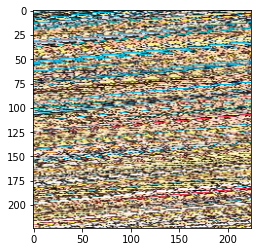

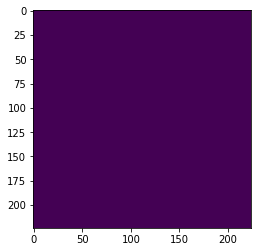

In [94]:
plt.imshow(train_images[0].numpy())
plt.show() 

plt.imshow(train_labels[0].numpy())
plt.show() 

In [63]:
n1 = int(4 * 0.34)
n2 = 4 - n1

print(n1, n2)

sg1 = SegmGenerator(waldo_sub_imgs, waldo_sub_labels, 1, shape=224, train=True)
sg2 = SegmGenerator(imgs, labels, 3, shape = 224, train=True, waldo=False)

out1 = sg1.__next__()
out2 = sg2.__next__()
# print(sg1.__next__()[0].shape, sg1.__next__()[1].shape)
# print(sg2.__next__()[0].shape, sg2.__next__()[1].shape)

print(out1[0].shape, out2[0].shape, np.concatenate((out1[0], out2[0])).shape)

# print(np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1])))

1 3
(1, 224, 224, 3) (3, 224, 224, 3) (4, 224, 224, 3)


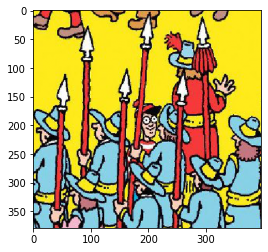

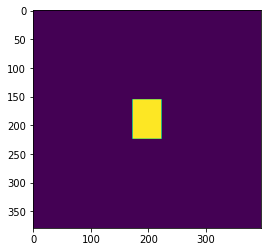

In [3]:
plt.imshow(waldo_sub_imgs[0])
plt.show() 

plt.imshow(waldo_sub_labels[0])
plt.show() 


In [4]:
PANNEL_SIZE = 224

class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default False 
    
    """
    def __init__(self, len, batch_size, shuffle=False):
        self.len = len
        self.batch_size = batch_size
        self.shuffle = len,batch_size,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.len) 
                     if self.shuffle else np.arange(0, self.len))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.len: 
                self.reset()
            ni = min(self.batch_size, self.len-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        


In [5]:
class SegmGenerator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, batch_size=64, shape=224, train=True, waldo=True):
        self.x = x 
        self.y = y
        self.batch_size = batch_size
        self.train = train
        self.waldo = waldo
        self.len = x.shape[0]
        self.width = [] 
        self.height = []

        for i in range(self.len):
            width, height, _ = x[i].shape
            self.width.append(width), self.height.append(height) 

        self.idx_gen = BatchIndices(self.len, batch_size, train)
        # self.ro, self.co = (shape, shape)
        self.res_width = shape
        self.res_height = shape
        self.y_channel = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, begin, end):
        start = random.randint(0, begin - end) if self.train else (begin - end)
        return slice(start, start + end)

    def get_item(self, idx):
        slice_width = self.get_slice(self.width[idx], self.res_width)
        slice_height = self.get_slice(self.height[idx], self.res_height)
        
        x = self.x[idx][slice_width, slice_height]
        y = self.y[idx][slice_width, slice_height]
        
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
            
        if not self.waldo and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
                
        if not items:
            return None
        
        xs, ys = zip(*tuple(items))
        
        return np.stack(xs), np.stack(ys)

In [6]:
def seg_gen_mix(w_imgs, w_lbls, imgs, lbls, batch_size=4, prop=0.34, shape=(224,224), train=True):
    """
    Mixes generator output. The second generator is set to skip images that contain any positive targets.
    # Arguments
        x1, y1: input/targets for waldo sub-images
        x2, y2: input/targets for whole images
        tot_bs: total batch size
        prop: proportion of total batch size consisting of first generator output
    """
    n1 = int(batch_size * prop)
    n2 = batch_size - n1
    sg1 = SegmGenerator(w_imgs, w_lbls, n1, shape=shape, train=train)
    sg2 = SegmGenerator(imgs, lbls, n2, shape = shape, train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

(4, 224, 224, 3) 4
(4, 224, 224, 3) 4
(4, 224, 224, 3) 4
(4, 224, 224, 3) 4


C:\Users\krsty\AppData\Local\Temp/ipykernel_15916/3866461615.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


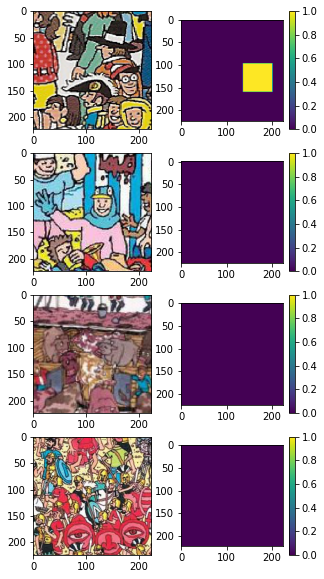

In [35]:
# waldo : not_waldo = 1 : 2 (0.34)
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, batch_size=4, prop=0.34, shape=PANNEL_SIZE)

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    print(X.shape, X.shape[0])
    
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

In [8]:
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, batch_size=4, prop=0.34, shape=PANNEL_SIZE)

X, y = next(gen_mix)

X.shape, y.shape

((4, 224, 224, 3), (4, 50176, 2))

88666846 37154


C:\Users\krsty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\krsty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2680: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(a, bins, orientation=orientation,


<AxesSubplot:>

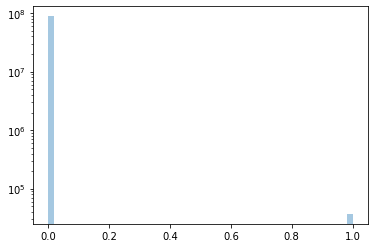

In [9]:
freq0 = np.sum(labels==0)
freq1 = np.sum(labels==1)

print(freq0, freq1)

sns.distplot(labels.flatten(), kde=False, hist_kws={'log':True})

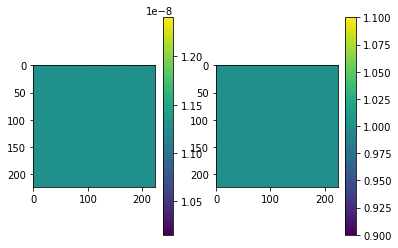

In [21]:
sample_weights = np.zeros((6, PANNEL_SIZE * PANNEL_SIZE, 2))

sample_weights[:,:,0] = 1. / freq0
sample_weights[:,:,1] = 1.

plt.subplot(1,2,1)
plt.imshow(sample_weights[0,:,0].reshape((224, 224)))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sample_weights[0,:,1].reshape((224, 224)))
plt.colorbar()


# sample_weights_for_0 = 1. / freq0
# sample_weights_for_1 = 1. 

# sample_weights = {0: sample_weights_for_0, 1: sample_weights_for_1}

# print(freq0)
# print('Weight for class 0: {:.2f}'.format(sample_weights_for_0))
# print('Weight for class 1: {:.2f}'.format(sample_weights_for_1))

In [11]:
def create_model(): 
    inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

    net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_1 = net

    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

    net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_3 = net

    net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.UpSampling2D(size=2)(net)
    net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
    net = layers.Activation('relu')(net)

    net = layers.Add()([net, shortcut_3])

    net = layers.UpSampling2D(size=2)(net)
    net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
    net = layers.Activation('relu')(net)

    net = layers.Add()([net, shortcut_2])

    net = layers.UpSampling2D(size=2)(net)
    net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
    net = layers.Activation('relu')(net)

    net = layers.Add()([net, shortcut_1])

    net = layers.UpSampling2D(size=2)(net)
    net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

    net = layers.Reshape((-1, 2))(net)
    net = layers.Activation('softmax')(net)

    model = Model(inputs=inputs, outputs=net)
    
    return model


In [12]:
model = create_model()


model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy'], 
    sample_weight_mode='temporal'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [18]:
gen_mix = seg_gen_mix(waldo_sub_imgs, 
                      waldo_sub_labels, 
                      imgs, 
                      labels, 
                      batch_size=6, 
                      prop=0.34, 
                      shape=PANNEL_SIZE)



In [30]:
def on_epoch_end(epoch, logs):
    print('\r', 'Epoch:%5d - loss: %.4f - acc: %.4f' % (epoch, logs['loss'], logs['accuracy']), end='')

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [36]:
X, y = next(gen_mix)

# np.unique(y)
# plt.figure(figsize=(5, 10))
# for i, img in enumerate(X):
    # plt.subplot(X.shape[0], 2, 2*i+1)
    # plt.imshow(X[i])
    # plt.subplot(X.shape[0], 2, 2*i+2)
    # plt.colorbar()
    # plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))

array([0., 1.], dtype=float32)

In [43]:
# sample_weights.shape
# gen_mix
sample_weights.shape 

(6, 50176, 2)

In [37]:
history = model.fit_generator(
    gen_mix, 
    steps_per_epoch=6, 
    epochs=5, 
    class_weight=sample_weights,
    # class_weight={0: 0.7, 1: 0.3},
    verbose=0,
    callbacks=[
        print_callback,
        ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, mode='auto', min_lr=1e-05)
    ]
)


C:\Users\krsty\AppData\Local\Temp/ipykernel_15916/2599338360.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [39]:
array1 = np.arange(100)

array1

filter1 = np.where(array1 % 7 == 0 and array1 > 50)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [42]:
# filter1 = np.where((array1 % 7 == 0) & (array1 > 50))
array1 % 7 == 0, array1 > 50



(array([ True, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True,
        False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fal

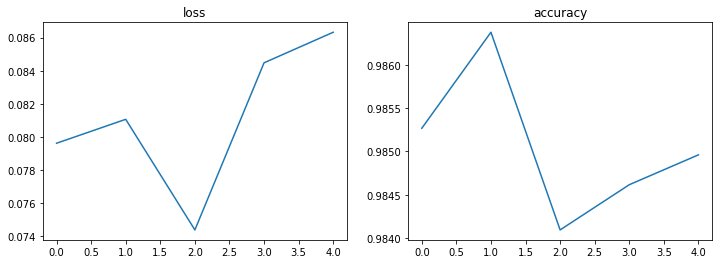

In [29]:

model.save('model.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
plt.plot(history.history['loss'])
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.plot(history.history['accuracy'])

In [ ]:
img_filename = '02.jpg'
test_img = np.array(Image.open(os.path.join('test_imgs', img_filename)).resize((2800, 1760), Image.NEAREST)).astype(np.float32) / 255.

plt.figure(figsize=(20, 10))
plt.imshow(test_img)

In [ ]:
def img_resize(img):
    h, w, _ = img.shape
    nvpanels = int(h/PANNEL_SIZE)
    nhpanels = int(w/PANNEL_SIZE)
    new_h, new_w = h, w
    if nvpanels*PANNEL_SIZE != h:
        new_h = (nvpanels+1)*PANNEL_SIZE
    if nhpanels*PANNEL_SIZE != w:
        new_w = (nhpanels+1)*PANNEL_SIZE
    if new_h == h and new_w == w:
        return img
    else:
        return resize(img, output_shape=(new_h, new_w), preserve_range=True)

def split_panels(img):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    panels = []
    for i in range(num_vert_panels):
        for j in range(num_hor_panels):
            panels.append(img[i*PANNEL_SIZE:(i+1)*PANNEL_SIZE,j*PANNEL_SIZE:(j+1)*PANNEL_SIZE])
    return np.stack(panels)

def combine_panels(img, panels):
    h, w, _ = img.shape
    num_vert_panels = int(h/PANNEL_SIZE)
    num_hor_panels = int(w/PANNEL_SIZE)
    total = []
    p = 0
    for i in range(num_vert_panels):
        row = []
        for j in range(num_hor_panels):
            row.append(panels[p])
            p += 1
        total.append(np.concatenate(row, axis=1))
    return np.concatenate(total, axis=0)

In [ ]:
test_img = img_resize(test_img)

panels = split_panels(test_img)

out = combine_panels(test_img, panels)

print(panels.shape, test_img.shape, out.shape)

# plt.imshow(panels[67])

In [ ]:
model = load_model('model.h5')

pred_panels = model.predict(panels).reshape((-1, PANNEL_SIZE, PANNEL_SIZE, 2))[:, :, :, 1]

pred_out = combine_panels(test_img, pred_panels)

# compute coordinates and confidence
argmax_x = np.argmax(np.max(pred_out, axis=0), axis=0)
argmax_y = np.argmax(np.max(pred_out, axis=1), axis=0)
confidence = np.amax(pred_out) * 100

print('(%s, %s) %.2f%%' % (argmax_x, argmax_y, confidence))

plt.figure(figsize=(20, 10))
plt.imshow(pred_out)
plt.colorbar()

In [ ]:
def bbox_from_mask(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return x1, y1, x2, y2

x1, y1, x2, y2 = bbox_from_mask((pred_out > 0.8).astype(np.uint8))
print(x1, y1, x2, y2)

# make overlay
overlay = np.repeat(np.expand_dims(np.zeros_like(pred_out, dtype=np.uint8), axis=-1), 3, axis=-1)
alpha = np.expand_dims(np.full_like(pred_out, 255, dtype=np.uint8), axis=-1)

overlay = np.concatenate([overlay, alpha], axis=-1)

overlay[y1:y2, x1:x2, 3] = 0

plt.figure(figsize=(20, 10))
plt.imshow(overlay)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(test_img)
ax.imshow(overlay, alpha=0.5)

rect = patches.Rectangle((x1, y1), width=x2-x1, height=y2-y1, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.set_axis_off()

fig.savefig(os.path.join('test_result', img_filename), bbox_inches='tight')